In [97]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBClassifier    

# https://blog.51cto.com/u_15521344/5061694#_2

In [98]:
path = './data/income/adult.data'
df = pd.read_csv(path, header = None, names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',  'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])
df['workclass'].mode()[0]
trans = {'workclass' : df['workclass'].mode()[0]}
df.fillna(trans, inplace = True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [99]:
df.replace(" ?", pd.NaT, inplace = True)
df.replace(" >50K", 1, inplace = True)
df.replace(" <=50K", 0, inplace = True)
        
trans = {'workclass' : df['workclass'].mode()[0], 'occupation' : df['occupation'].mode()[0], 'native-country' : df['native-country'].mode()[0]}
df.fillna(trans, inplace = True)
df.drop('fnlwgt', axis = 1, inplace = True)
df.drop('capital-gain', axis = 1, inplace = True)
df.drop('capital-loss', axis = 1, inplace = True)

df_object_col = [col for col in df.columns if df[col].dtype.name == 'object']
df_int_col = [col for col in df.columns if df[col].dtype.name != 'object' and col != 'income']
y = df["income"]
df = pd.concat([df[df_int_col], pd.get_dummies(df[df_object_col])], axis = 1)
df.head()

,age,education-num,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,13,40,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,50,13,13,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,38,9,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,7,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,13,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: income, Length: 32561, dtype: int64

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state = 400)

In [100]:
model = XGBClassifier(
                        learning_rate =0.05,
                         n_estimators=100,
                         max_depth=3,
                         min_child_weight=1,
                         gamma=0.3,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective= 'multi:softprob',
                         nthread=4,
                         scale_pos_weight=1,
                         num_class=2,
                         seed=27,
                    ).fit(X_train, y_train)

[15:43:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




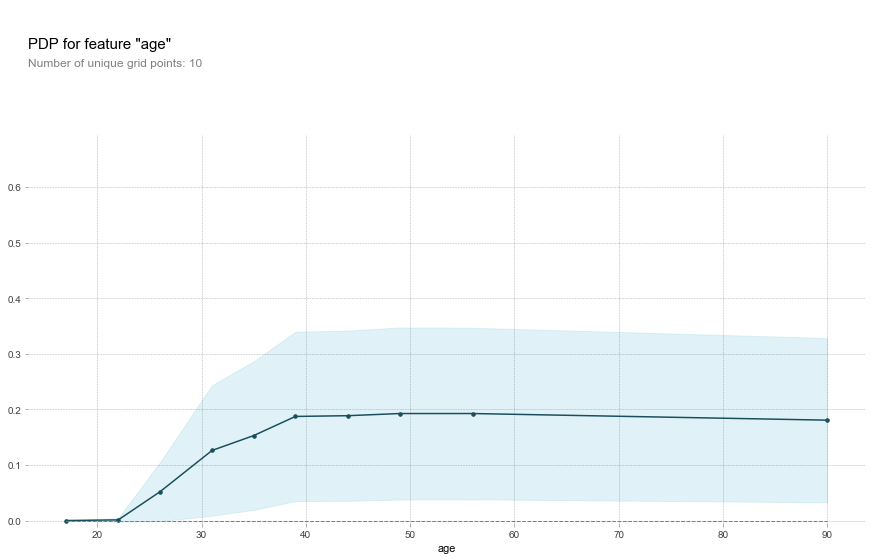

In [105]:
from pdpbox import pdp

feature = 'age'
# 创建好画图所需的数据
pdp_goals = pdp.pdp_isolate(model, X_test, df.columns, feature)
# 画出“age”这一特征的partial dependence plot
pdp.pdp_plot(pdp_goals, feature)
plt.show()

In [104]:
X_train.head()
y_train.head()


13325    0
555      0
29097    0
13344    0
3173     0
Name: income, dtype: int64

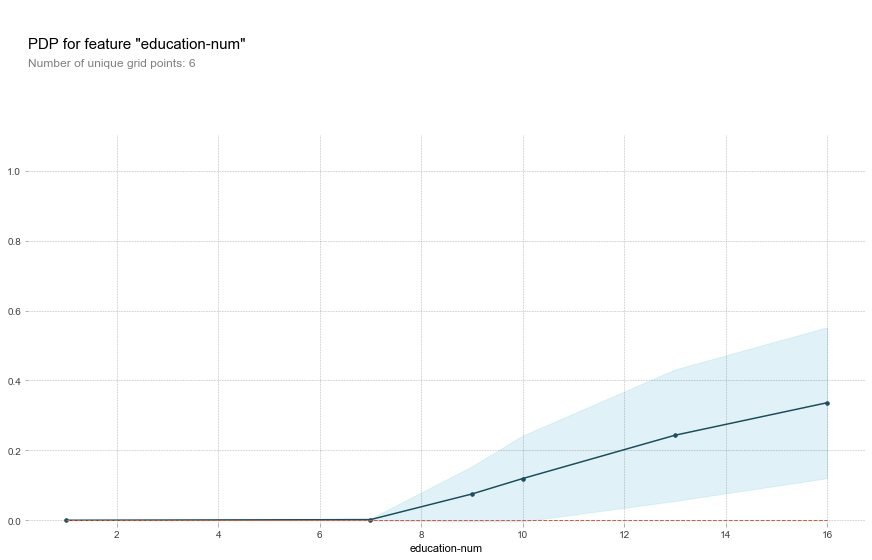

In [78]:
feature = 'education-num'
pdp_goals = pdp.pdp_isolate(model, y_train, df.columns, feature)
pdp.pdp_plot(pdp_goals, feature)
plt.show()

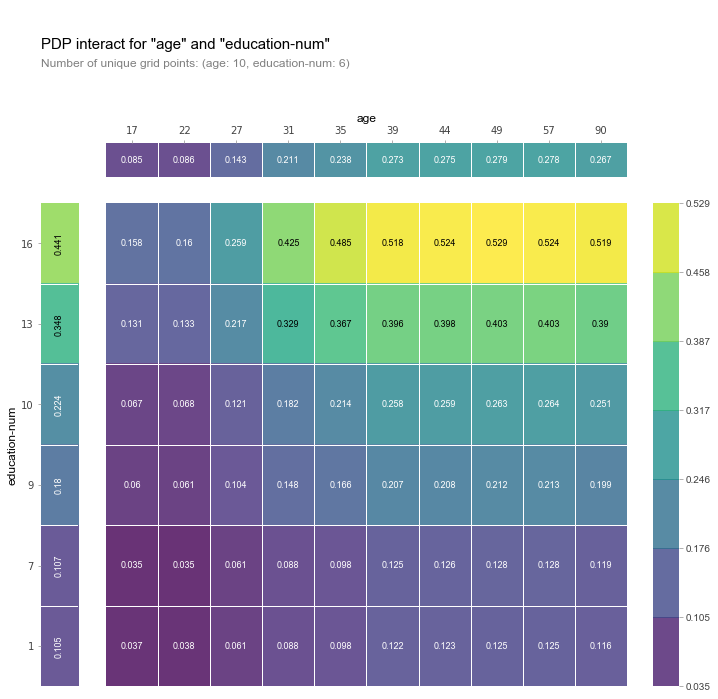

In [93]:
features_to_plot = ['age', 'education-num']
inter1  = pdp.pdp_interact(model, df, df.columns, features_to_plot)
pdp.pdp_interact_plot(inter1, features_to_plot, plot_type='grid', x_quantile=True, ncols = 2, plot_pdp=True)
plt.show()

In [116]:
import shap
from lime.lime_tabular import LimeTabularExplainer

In [151]:
categorical_features = [index for index, row in df.iteritems() if df["education-num"].unique().size < 10]
feature_names = df.columns
df["education-num"].unique().size

16